In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 设置显示选项
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print('Libraries loaded successfully!')

Libraries loaded successfully!


## 1. 加载数据

In [2]:
# 加载训练和测试数据
DATA_DIR = Path('.')

train_df = pd.read_csv(DATA_DIR / 'train.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')

print(f'训练集形状: {train_df.shape}')
print(f'测试集形状: {test_df.shape}')
print(f'\n训练集列数: {len(train_df.columns)}')
print(f'测试集列数: {len(test_df.columns)}')

训练集形状: (9021, 98)
测试集形状: (10, 99)

训练集列数: 98
测试集列数: 99


In [ ]:
# 查看训练集前几行
train_df.head()

In [ ]:
# 查看测试集前几行
test_df.head()

## 2. 特征分类分析

In [3]:
# 按前缀分类特征
feature_categories = {
    'D': '虚拟/二进制标志',
    'E': '宏观经济指标',
    'I': '利率变量',
    'M': '市场动态/技术指标',
    'P': '价格/估值指标',
    'S': '情绪变量',
    'V': '波动率指标',
    'MOM': '动量指标'
}

# 统计每类特征数量
feature_cols = [col for col in train_df.columns if col not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']]

category_counts = {}
categorized_features = {cat: [] for cat in feature_categories.keys()}

for col in feature_cols:
    for prefix in ['MOM', 'D', 'E', 'I', 'M', 'P', 'S', 'V']:  # MOM先检查因为它更长
        if col.startswith(prefix):
            categorized_features[prefix].append(col)
            break

print('特征类别统计:')
print('=' * 50)
for prefix, name in feature_categories.items():
    count = len(categorized_features[prefix])
    print(f'{prefix}: {name} - {count}个特征')

print(f'\n总特征数: {len(feature_cols)}')

特征类别统计:
D: 虚拟/二进制标志 - 9个特征
E: 宏观经济指标 - 20个特征
I: 利率变量 - 9个特征
M: 市场动态/技术指标 - 18个特征
P: 价格/估值指标 - 13个特征
S: 情绪变量 - 12个特征
V: 波动率指标 - 13个特征
MOM: 动量指标 - 0个特征

总特征数: 94


In [ ]:
# 查看各类特征的名称
for prefix, features in categorized_features.items():
    if features:
        print(f'\n{prefix}类特征 ({feature_categories[prefix]}):')
        print(features)

## 3. 缺失值分析

In [4]:
# 计算每列缺失值比例
missing_ratio = train_df.isnull().sum() / len(train_df) * 100
missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)

print(f'有缺失值的列数: {len(missing_ratio)}')
print(f'\n缺失值比例最高的10个特征:')
print(missing_ratio.head(10))

有缺失值的列数: 85

缺失值比例最高的10个特征:
E7     77.253076
V10    67.054650
S3     63.551713
M1     61.489857
M13    61.412260
M14    61.412260
M6     55.902893
V9     50.315929
S12    39.208513
M5     36.392861
dtype: float64


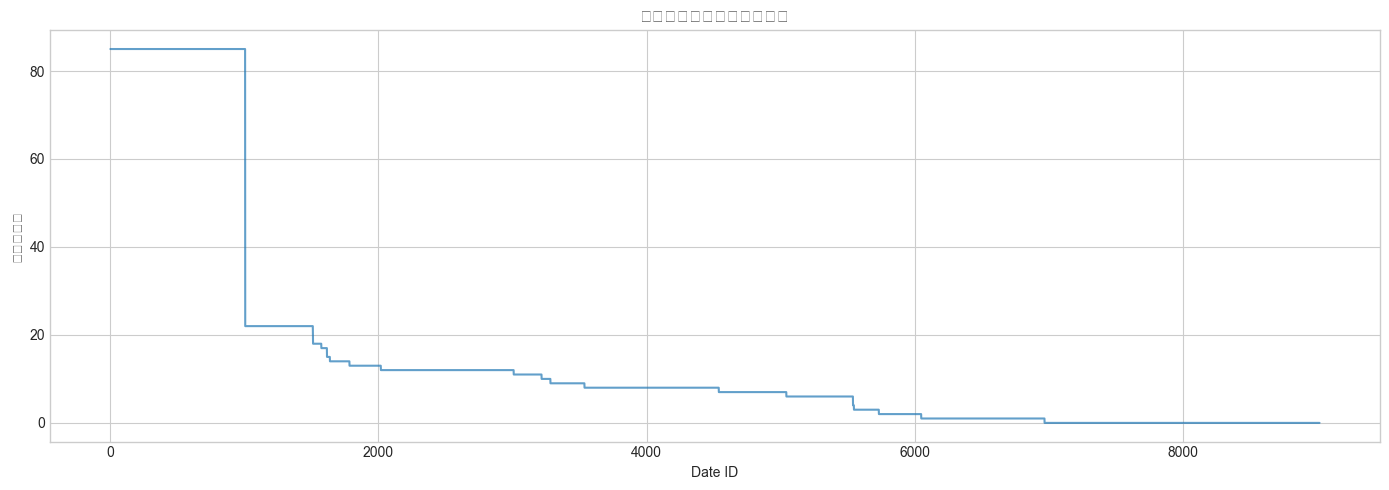


缺失值为0的交易日数: 2052
缺失值 > 50% 特征的交易日数: 1006


In [6]:
# 可视化缺失值按date_id的分布
missing_by_date = train_df.isnull().sum(axis=1)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_df['date_id'], missing_by_date, alpha=0.7)
ax.set_xlabel('Date ID')
ax.set_ylabel('缺失特征数')
ax.set_title('每个交易日的缺失特征数量')
plt.tight_layout()
plt.show()

print(f'\n缺失值为0的交易日数: {(missing_by_date == 0).sum()}')
print(f'缺失值 > 50% 特征的交易日数: {(missing_by_date > len(feature_cols) * 0.5).sum()}')

In [7]:
# 找出数据相对完整的起始点
# 寻找缺失值小于5%的第一个date_id
threshold = len(feature_cols) * 0.05
complete_data_start = train_df[missing_by_date <= threshold]['date_id'].min()
print(f'缺失值 <= 5% 的起始date_id: {complete_data_start}')
print(f'数据完整部分的样本数: {(train_df["date_id"] >= complete_data_start).sum()}')

缺失值 <= 5% 的起始date_id: 5540
数据完整部分的样本数: 3481


## 4. 目标变量分析

In [8]:
# 目标变量统计
target_cols = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

print('目标变量统计描述:')
print(train_df[target_cols].describe())

目标变量统计描述:
       forward_returns  risk_free_rate  market_forward_excess_returns
count      9021.000000     9021.000000                    9021.000000
mean          0.000471        0.000107                       0.000053
std           0.010541        0.000088                       0.010558
min          -0.039754       -0.000004                      -0.040582
25%          -0.004319        0.000008                      -0.004747
50%           0.000659        0.000097                       0.000255
75%           0.005896        0.000193                       0.005479
max           0.040661        0.000317                       0.040551


In [ ]:
# 可视化目标变量分布
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(target_cols):
    axes[i].hist(train_df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}\nmean={train_df[col].mean():.6f}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# forward_returns 随时间的变化
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 日收益率
axes[0].plot(train_df['date_id'], train_df['forward_returns'], alpha=0.6)
axes[0].set_xlabel('Date ID')
axes[0].set_ylabel('Forward Returns')
axes[0].set_title('每日远期收益率')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 累积收益
cumulative_returns = (1 + train_df['forward_returns']).cumprod()
axes[1].plot(train_df['date_id'], cumulative_returns, alpha=0.8)
axes[1].set_xlabel('Date ID')
axes[1].set_ylabel('Cumulative Returns')
axes[1].set_title('累积收益率')

plt.tight_layout()
plt.show()

In [9]:
# 收益率的正负比例
positive_returns = (train_df['forward_returns'] > 0).sum()
negative_returns = (train_df['forward_returns'] < 0).sum()
zero_returns = (train_df['forward_returns'] == 0).sum()

print(f'正收益天数: {positive_returns} ({positive_returns/len(train_df)*100:.1f}%)')
print(f'负收益天数: {negative_returns} ({negative_returns/len(train_df)*100:.1f}%)')
print(f'零收益天数: {zero_returns}')

正收益天数: 4866 (53.9%)
负收益天数: 4095 (45.4%)
零收益天数: 60


## 5. 特征与目标的相关性分析

In [ ]:
# 计算特征与forward_returns的相关性
# 只使用数据完整的部分
train_complete = train_df[train_df['date_id'] >= complete_data_start].copy()
print(f'使用完整数据进行相关性分析，样本数: {len(train_complete)}')

correlations = {}
for col in feature_cols:
    if col in train_complete.columns:
        valid_data = train_complete[[col, 'forward_returns']].dropna()
        if len(valid_data) > 100:  # 需要足够的数据
            corr = valid_data[col].corr(valid_data['forward_returns'])
            correlations[col] = corr

corr_series = pd.Series(correlations).sort_values(key=abs, ascending=False)
print(f'\n与forward_returns相关性最高的20个特征:')
print(corr_series.head(20))

In [ ]:
# 可视化top特征的相关性
top_features = corr_series.head(20)

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in top_features.values]
ax.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features.index)
ax.set_xlabel('Correlation with forward_returns')
ax.set_title('Top 20 特征与远期收益的相关性')
ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. 特征统计分析

In [ ]:
# 各类特征的基本统计
print('各类特征的统计描述:')
for prefix, features in categorized_features.items():
    if features:
        print(f'\n=== {prefix}类特征 ({feature_categories[prefix]}) ===')
        print(train_complete[features].describe().T[['mean', 'std', 'min', 'max']])

In [ ]:
# D类特征分布（虚拟变量）
d_features = categorized_features['D']
if d_features:
    print('D类特征（虚拟变量）的取值分布:')
    for col in d_features:
        value_counts = train_df[col].value_counts(normalize=True)
        print(f'{col}: {dict(value_counts.round(3))}')

## 7. 测试集分析

In [ ]:
# 测试集特有列
test_only_cols = set(test_df.columns) - set(train_df.columns)
print(f'测试集特有的列: {test_only_cols}')

# 查看is_scored分布
if 'is_scored' in test_df.columns:
    print(f'\nis_scored分布:')
    print(test_df['is_scored'].value_counts())

In [ ]:
# 查看测试集的lagged变量
lagged_cols = ['lagged_forward_returns', 'lagged_risk_free_rate', 'lagged_market_forward_excess_returns']
print('测试集lagged变量统计:')
print(test_df[lagged_cols].describe())

## 8. 数据预处理建议总结

In [ ]:
print('=' * 60)
print('数据探索总结与预处理建议')
print('=' * 60)
print(f'''
1. 数据规模:
   - 训练集: {train_df.shape[0]} 条记录, {train_df.shape[1]} 列
   - 测试集: {test_df.shape[0]} 条记录, {test_df.shape[1]} 列
   - 特征数: {len(feature_cols)}

2. 缺失值处理:
   - 早期数据缺失严重，建议从date_id >= {complete_data_start}开始使用
   - 或使用前向填充/插值方法处理缺失值

3. 特征类别:
   - D: 虚拟变量 (二分类)
   - E: 宏观经济指标
   - I: 利率变量
   - M: 市场动态/技术指标
   - P: 价格/估值指标
   - S: 情绪变量
   - V: 波动率指标

4. 目标变量:
   - forward_returns: 次日收益率，正收益约占{positive_returns/len(train_df)*100:.1f}%
   - 需要预测的是投资权重(0-2)，不是直接预测收益

5. 建议的模型策略:
   - 考虑波动率自适应权重
   - 使用滚动窗口特征
   - 集成多个信号
''')